# Data Collection

Needed to gather historical data regarding player, teams, etc.

Fortunately, [ESPN Scrum](espnscrum.com) provides a data on players, teams, and matches going back to 1896. 

Using a scrapy spider built by peloyeje (found [here](https://github.com/peloyeje/map536-rugby-data-scraper)), it was possible to collect a meaningful sample of matches and results, along with player stats for each match to work with.

Additionally, the World Rugby rankings were gathered from World Rugby's website using Beautiful Soup.

In [58]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [59]:
data = pd.read_csv("rankings.csv")

data

,team_name,abbreviation,num_matches,pts,pos,prev_pts,prev_pos,date
0,England,ENG,11,89.948520,1,89.948520,1,2003-10-13
1,New Zealand,NZL,11,89.797710,2,89.797710,2,2003-10-13
2,Australia,AUS,11,84.762690,3,83.805620,4,2003-10-13
3,Ireland,IRE,11,83.924580,4,83.924580,3,2003-10-13
4,France,FRA,11,82.845314,5,82.845314,5,2003-10-13
...,...,...,...,...,...,...,...,...
577110,Monaco,MON,12,23.171558,101,23.171558,101,2019-11-14
577111,Greece,GRE,17,22.546452,102,22.546452,102,2019-11-14
577112,Indonesia,INA,5,21.891422,103,21.891422,103,2019-11-14
577113,Vanuatu,VAN,16,21.453693,104,21.453693,104,2019-11-14


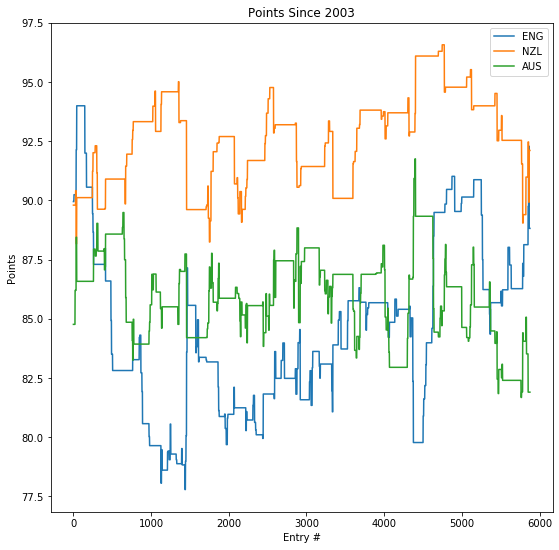

In [66]:
eng_pts = data.loc[data.abbreviation == 'ENG'].values[:,[3]]
# eng_dates = data.loc[data.abbreviation == 'ENG'].values[:,[7]]

nzl_pts = data.loc[data.abbreviation == 'NZL'].values[:,[3]]

aus_pts = data.loc[data.abbreviation == 'AUS'].values[:,[3]]

datetime

fig = plt.figure(figsize=(9, 9))

plt.plot(eng_pts, label='ENG')
plt.plot(nzl_pts, label='NZL')
plt.plot(aus_pts, label='AUS')

plt.title("Points Since 2003")
plt.xlabel("Entry #")
plt.ylabel("Points")

plt.legend()

plt.show()